In [63]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

import os
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [64]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [65]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Generating some data points

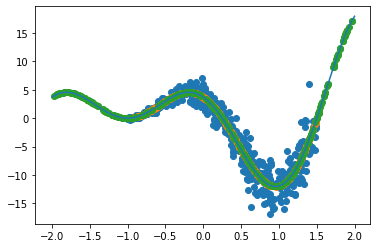

In [160]:
def func(x, noise=False, eps1=0.0, eps2=0.0):
    b1 = 0.1 #0.5
    b2 = 0.05 # 0.12
    x_max = 4*np.pi
    x_min = 1.0
    xt = (x_min+x)*x_max
    if noise:
        return 0.5*xt*np.sin(0.2*xt) + b1*eps1 + b2*eps2*xt
    else:
        return 0.5*xt*np.sin(0.2*xt)
    
n_train = 500
n_val = 300

# random x values
# training data
x_train = np.random.uniform(-1.0, 1.5, n_train)
x_train = np.sort(x_train)
# validation data
x_val = np.random.uniform(-2.0,2.0, n_val)
x_val = np.sort(x_val)
x_val_in = np.random.uniform(-1.0,1.5, n_val)
x_val_in = np.sort(x_val_in)
# create noise labels
eps1 = np.random.normal(0, 1, n_train)
eps2 = np.random.normal(0, 2, n_train)
y_train = func(x_train, True, eps1, eps2)
# true mean
m_train = func(x_train)
m_val = func(x_val)

# plot training and validation data
plt.scatter(x_train, y_train)
plt.scatter(x_train, m_train)
xe = np.linspace(-2.0, 2.0, n_val)
ye = func(xe)
plt.plot(xe, ye)
plt.scatter(x_val, m_val)

# Discriminative model

In [161]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[1]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

inp = layers.Input([1])
x = layers.Dense(64, activation='relu')(inp)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1)(x)
model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(loss='mae',
              optimizer=tf.optimizers.Adam(learning_rate=0.01),
              metrics=['mae', 'mse'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________

In [172]:
EPOCHS = 500
history = model.fit(x_train,y_train, epochs=EPOCHS, verbose=1)

Train on 500 samples
Epoch 1/500
500/500 [==============================] - 0s 77us/sample - loss: 1.6992 - mae: 1.6992 - mse: 5.4368
Epoch 2/500
500/500 [==============================] - 0s 47us/sample - loss: 1.7236 - mae: 1.7236 - mse: 5.9090
Epoch 3/500
500/500 [==============================] - 0s 48us/sample - loss: 1.7559 - mae: 1.7559 - mse: 5.8361
Epoch 4/500
500/500 [==============================] - 0s 199us/sample - loss: 1.7497 - mae: 1.7497 - mse: 6.2314
Epoch 5/500
500/500 [==============================] - 0s 49us/sample - loss: 1.7194 - mae: 1.7194 - mse: 6.0315
Epoch 6/500
500/500 [==============================] - 0s 46us/sample - loss: 1.8117 - mae: 1.8117 - mse: 6.7881
Epoch 7/500
500/500 [==============================] - 0s 55us/sample - loss: 1.7025 - mae: 1.7025 - mse: 5.6729
Epoch 8/500
500/500 [==============================] - 0s 47us/sample - loss: 1.8339 - mae: 1.8339 - mse: 7.1450
Epoch 9/500
500/500 [==============================] - 0s 150us/sample - l

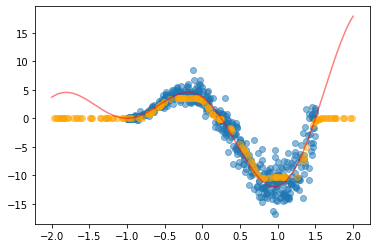

In [173]:
# plot predictions 
y_pred = model.predict(x_val)
plt.scatter(x_train, y_train, alpha=0.5)
xe = np.linspace(-2.0, 2.0, n_val)
ye = func(xe)
plt.plot(xe, ye, 'red', alpha=0.5)
plt.scatter(x_val, y_pred, c='orange',alpha=0.5)

## Aleatoric uncertainty

In [76]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [170]:
model_aleatoric = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[1]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1 + 1),
    #tfp.layers.DistributionLambda(
    #  lambda t: tfp.distributions.Normal(loc=t[..., :1],
    #                                     scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),])
    ])

def mse(y_true, y_pred):
    return tf.losses.MSE(tf.squeeze(y_true), 
                         tf.squeeze(y_pred[:, 0]))

def mae(y_true, y_pred):
    return tf.losses.MAE(tf.squeeze(y_true), 
                         tf.squeeze(y_pred[:, 0]))
    
def loss_nloglik(y_true, y_pred):
    log_sigma2 = y_pred[:, 1]
    mean = y_pred[:, 0]
    nloglik = tf.reduce_mean(0.5*tf.math.exp(-log_sigma2)*(tf.squeeze(y_true) - mean)**2 + 0.5*log_sigma2)
    return nloglik

model_aleatoric.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                        loss=loss_nloglik,
                        metrics=[mae, mse])
model_aleatoric.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 130       
Total params: 4,418
Trainable params: 4,418
Non-trainable params: 0
_________________________________________________________________


In [171]:
EPOCHS=500
model_aleatoric.fit(x_train, y_train, epochs=EPOCHS, verbose=True)

Train on 500 samples
Epoch 1/500
500/500 [==============================] - 1s 2ms/sample - loss: 6.3630 - mae: 4.8483 - mse: 40.3248
Epoch 2/500
500/500 [==============================] - 0s 141us/sample - loss: 2.3528 - mae: 4.4586 - mse: 34.9786
Epoch 3/500
500/500 [==============================] - 0s 154us/sample - loss: 1.9493 - mae: 4.5157 - mse: 36.9322
Epoch 4/500
500/500 [==============================] - 0s 89us/sample - loss: 1.8196 - mae: 3.7670 - mse: 24.8694
Epoch 5/500
500/500 [==============================] - 0s 110us/sample - loss: 1.6526 - mae: 2.9530 - mse: 14.5030
Epoch 6/500
500/500 [==============================] - 0s 92us/sample - loss: 1.4542 - mae: 2.3607 - mse: 10.3255
Epoch 7/500
500/500 [==============================] - 0s 122us/sample - loss: 1.2903 - mae: 2.1690 - mse: 11.2949
Epoch 8/500
500/500 [==============================] - 0s 92us/sample - loss: 1.0286 - mae: 1.9231 - mse: 9.8353
Epoch 9/500
500/500 [==============================] - 0s 94us/sa


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



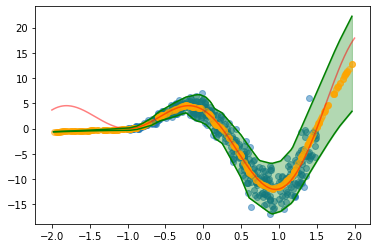

In [172]:
# plot predictions 
y_pred = model_aleatoric(x_val[...,np.newaxis])
plt.scatter(x_train, y_train, alpha=0.5)
xe = np.linspace(-2.0, 2.0, n_val)
ye = func(xe)
plt.plot(xe, ye,c='red', alpha=0.5)
pred_mean = y_pred[:, 0].numpy()
#pred_mean = pred_mean.squeeze()
pred_std = np.sqrt(np.exp(y_pred[:, 1].numpy()))
#pred_std = pred_std.squeeze()
plt.fill_between(x_val, 
                pred_mean + 2.0*pred_std, 
                pred_mean - 2.0*pred_std,
                 alpha=0.3, color='green')
plt.scatter(x_val, pred_mean, c='orange', alpha=0.5)
plt.plot(x_val, pred_mean + 2.0*pred_std,c='green')
plt.plot(x_val, pred_mean - 2.0*pred_std,c='green')

In [174]:
# Export datapoints
tmp = np.stack([x_val,pred_mean, pred_mean - 2.0*pred_std, pred_mean + 2.0*pred_std], axis=1)
for i in range(tmp.shape[0]):
    print(f'{tmp[i, 0]:.3f} {tmp[i, 1]:.3f} {tmp[i, 2]:.3f} {tmp[i, 3]:.3f}')

-1.979 -0.618 -0.639 -0.596
-1.951 -0.603 -0.626 -0.580
-1.932 -0.593 -0.617 -0.569
-1.928 -0.591 -0.615 -0.567
-1.924 -0.589 -0.613 -0.564
-1.911 -0.582 -0.607 -0.556
-1.904 -0.578 -0.604 -0.553
-1.881 -0.566 -0.593 -0.538
-1.875 -0.562 -0.590 -0.535
-1.859 -0.554 -0.583 -0.525
-1.851 -0.550 -0.579 -0.521
-1.835 -0.541 -0.572 -0.511
-1.822 -0.535 -0.566 -0.503
-1.819 -0.533 -0.565 -0.501
-1.800 -0.523 -0.556 -0.489
-1.771 -0.507 -0.543 -0.472
-1.751 -0.497 -0.535 -0.459
-1.748 -0.496 -0.534 -0.458
-1.741 -0.492 -0.530 -0.453
-1.709 -0.475 -0.516 -0.433
-1.708 -0.474 -0.516 -0.432
-1.692 -0.466 -0.510 -0.422
-1.679 -0.459 -0.504 -0.413
-1.659 -0.448 -0.496 -0.401
-1.644 -0.440 -0.490 -0.391
-1.624 -0.430 -0.482 -0.378
-1.611 -0.423 -0.477 -0.369
-1.597 -0.416 -0.471 -0.360
-1.597 -0.416 -0.471 -0.360
-1.573 -0.403 -0.462 -0.344
-1.563 -0.398 -0.458 -0.337
-1.532 -0.382 -0.447 -0.317
-1.519 -0.375 -0.442 -0.308
-1.517 -0.374 -0.441 -0.306
-1.505 -0.367 -0.437 -0.298
-1.495 -0.362 -0.433

## Quantile Regression

In [162]:
model_quantile = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[1]),
    layers.Dense(64, activation='relu'),
    layers.Dense(3)
])

In [166]:
def quantile_loss(quantiles,y,fm):
    losses = []
    for i, q in enumerate(quantiles):
        f = fm[:, i]
        f = f[:, tf.newaxis]
        e = (y-f)
        loss = tf.reduce_mean(tf.maximum(q*e, (q-1)*e), axis=-1)
        losses.append(loss)
    return tf.reduce_mean(tf.add_n(losses))

model_quantile.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
                       loss=lambda y,f: quantile_loss([0.025, 0.5, 0.975],y,f),
                       metrics=['mae', 'mse'])
model_quantile.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 195       
Total params: 4,483
Trainable params: 4,483
Non-trainable params: 0
_________________________________________________________________


In [167]:
EPOCHS=500
model_quantile.fit(x_train, y_train, epochs=EPOCHS, verbose=True)

Train on 500 samples
Epoch 1/500
500/500 [==============================] - 1s 1ms/sample - loss: 0.9661 - mae: 1.6289 - mse: 5.2023
Epoch 2/500
500/500 [==============================] - 0s 111us/sample - loss: 0.8372 - mae: 2.0580 - mse: 7.4315
Epoch 3/500
500/500 [==============================] - 0s 111us/sample - loss: 0.8045 - mae: 2.2434 - mse: 8.7343
Epoch 4/500
500/500 [==============================] - 0s 108us/sample - loss: 0.7878 - mae: 2.2765 - mse: 9.1860
Epoch 5/500
500/500 [==============================] - 0s 109us/sample - loss: 0.7864 - mae: 2.2504 - mse: 9.3135
Epoch 6/500
500/500 [==============================] - 0s 113us/sample - loss: 0.7800 - mae: 2.2491 - mse: 9.5781
Epoch 7/500
500/500 [==============================] - 0s 104us/sample - loss: 0.7834 - mae: 2.2469 - mse: 9.7946
Epoch 8/500
500/500 [==============================] - 0s 107us/sample - loss: 0.7822 - mae: 2.3275 - mse: 10.3031
Epoch 9/500
500/500 [==============================] - 0s 106us/samp

Text(0.5, 1.0, 'quantile regression')

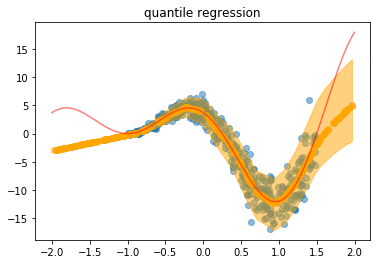

In [168]:
# plot predictions 
y_pred = model_quantile(x_val[...,np.newaxis])
plt.scatter(x_train, y_train, alpha=0.5)
xe = np.linspace(-2.0, 2.0, n_val)
ye = func(xe)
plt.plot(xe, ye,c='red', alpha=0.5)
plt.scatter(x_val, y_pred[:, 1], c='orange', alpha=0.6)
plt.fill_between(x_val, 
                y_pred[:, 0], 
                y_pred[:, 2],
                alpha=0.5, color='orange')
plt.title('quantile regression')

In [159]:
# Export datapoints
tmp = np.stack([x_val, y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]], axis=1)
for i in range(tmp.shape[0]):
    print(f'{tmp[i, 0]:.3f} {tmp[i, 1]:.3f} {tmp[i, 2]:.3f} {tmp[i, 3]:.3f}')

-1.926 -3.773 -3.854 -3.742
-1.920 -3.754 -3.832 -3.719
-1.907 -3.708 -3.779 -3.667
-1.906 -3.705 -3.775 -3.663
-1.901 -3.688 -3.756 -3.643
-1.880 -3.616 -3.674 -3.561
-1.852 -3.520 -3.564 -3.450
-1.818 -3.407 -3.435 -3.321
-1.780 -3.275 -3.284 -3.170
-1.712 -3.045 -3.020 -2.905
-1.707 -3.027 -3.000 -2.885
-1.684 -2.950 -2.911 -2.796
-1.682 -2.943 -2.904 -2.788
-1.672 -2.911 -2.866 -2.751
-1.625 -2.749 -2.682 -2.565
-1.624 -2.746 -2.678 -2.562
-1.593 -2.640 -2.557 -2.440
-1.527 -2.419 -2.304 -2.186
-1.521 -2.398 -2.280 -2.162
-1.513 -2.371 -2.249 -2.131
-1.497 -2.313 -2.185 -2.063
-1.483 -2.263 -2.129 -2.004
-1.445 -2.130 -1.983 -1.848
-1.400 -1.969 -1.805 -1.659
-1.397 -1.959 -1.795 -1.648
-1.369 -1.860 -1.685 -1.531
-1.327 -1.712 -1.523 -1.358
-1.316 -1.674 -1.481 -1.313
-1.250 -1.438 -1.222 -1.037
-1.238 -1.398 -1.177 -0.989
-1.218 -1.324 -1.096 -0.903
-1.200 -1.260 -1.026 -0.828
-1.193 -1.237 -1.001 -0.801
-1.189 -1.222 -0.984 -0.783
-1.179 -1.187 -0.945 -0.742
-1.172 -1.164 -0.920

## Epistemic uncertainty

### Keras

In [131]:
tfd = tfp.distributions

tmp = tfp.layers.default_mean_field_normal_fn(loc_initializer=tf.initializers.constant(0),
    untransformed_scale_initializer=tf.initializers.constant(0.000001))
# Initialize a single 2-variate Gaussian.
def prior(dtype, shape, name, trainable, add_variable_fn):
    
    loc_a = tf.zeros(shape)
    scale_a = tf.ones(shape)*1.0
    dist_a = tfp.distributions.Normal(loc=loc_a, scale=scale_a)
    dist_a = tfp.distributions.Independent(dist_a,
                                           reinterpreted_batch_ndims=tf.size(dist_a.batch_shape_tensor()))

    loc_b = tf.zeros(shape)
    scale_b = tf.ones(shape)*00000.1
    dist_b = tfp.distributions.Normal(loc=loc_b, scale=scale_b)
    dist_b = tfp.distributions.Independent(dist_b,
                                           reinterpreted_batch_ndims=tf.size(dist_b.batch_shape_tensor()))
    
    mix = 0.5
    bimix_gauss = tfd.Mixture(
          cat=tfd.Categorical(probs=[mix, 1.-mix]),
          components=[
            dist_a, dist_b
        ])
    
    #bimix_gauss = tfp.distributions.Independent(bmix_gauss,
     #                                           reinterpreted_batch_ndims=tf.size(bimix_gauss.batch_shape_tensor()))
  
    
    return dist_a
    #batch_ndims = tf.size(dist_a.batch_shape_tensor())
    #return tfp.distributions.Independent(
    #    dist_a, reinterpreted_batch_ndims=batch_ndims)
    #return dist_a
   # return dist

model_b = tf.keras.Sequential([
  tfp.layers.DenseReparameterization(64, activation='relu', input_shape=[1],
                                     kernel_prior_fn=prior),
  tfp.layers.DenseReparameterization(64, activation='relu',
                                     kernel_prior_fn=prior),
  tfp.layers.DenseReparameterization(1,
                                     kernel_prior_fn=prior)
])

x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

batch_size = 32
n_batches = n_train//batch_size

a_step = tf.keras.backend.variable(0.0)
global_epoch = tf.Variable(0.)

class StepCallback(tf.keras.callbacks.Callback):
    
    def on_train_batch_begin(self, batch, logs=None):
        #epoch = tf.keras.backend.get_value(global_epoch)
        #if epoch < 100:
        #    tf.keras.backend.set_value(a_step, 1/n_batches)
        #else:
        tf.keras.backend.set_value(a_step, 1/n_train)# 1/batch_size*2**(n_batches-batch)/(2**n_batches-1)) # 1/n_batches) 
        # tf.keras.backend.set_value(model.losses, 0.0)
        return
      
    
def custom_loss(y_true, y_pred):
    nloglik_loss = loss_nloglik(y_true, y_pred)
    kl_loss = loss_kl(y_true, y_pred)
    a = tf.keras.backend.get_value(a_step)
    #tf.print(a)
    #tf.print(a_step)
    loss = nloglik_loss + (a - 1) * kl_loss
    return loss

def loss_nloglik(y_true, y_pred):
    log_sigma2 = 0.0 # y_pred[:, 1]
    mean = y_pred[:, 0]
    nloglik = tf.reduce_mean(0.5*tf.math.exp(-log_sigma2)*(tf.squeeze(y_true) - mean)**2 + 0.5*log_sigma2)
    return nloglik

def loss_kl(y_true, y_pred):
    kl_loss = tf.keras.backend.get_value(model_b.losses)
    kl_loss = tf.reduce_sum(kl_loss)
    return kl_loss
    
model_b.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
                loss=lambda y_true, y_pred: custom_loss(y_true, y_pred),
                metrics=['mae', 'mse', loss_kl, loss_nloglik ])
model_b.summary()



Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_reparameterization_102 (None, 64)                192       
_________________________________________________________________
dense_reparameterization_103 (None, 64)                8256      
_________________________________________________________________
dense_reparameterization_104 (None, 1)                 129       
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


In [132]:
EPOCHS=800
   
history = model_b.fit(x_train, y_train, epochs=EPOCHS,
                      callbacks=[StepCallback()],
                      shuffle=True,
                      verbose=True)

Train on 150 samples
Epoch 1/800
150/150 [==============================] - 1s 9ms/sample - loss: 98.4463 - mae: 5.9282 - mse: 55.5164 - loss_kl: 10597.8154 - loss_nloglik: 28.2863
Epoch 2/800
150/150 [==============================] - 0s 230us/sample - loss: 92.6136 - mae: 5.5052 - mse: 46.5002 - loss_kl: 10399.3770 - loss_nloglik: 22.7054
Epoch 3/800
150/150 [==============================] - 0s 248us/sample - loss: 82.8911 - mae: 4.5303 - mse: 29.6195 - loss_kl: 10207.1992 - loss_nloglik: 14.4347
Epoch 4/800
150/150 [==============================] - 0s 304us/sample - loss: 77.4627 - mae: 3.6422 - mse: 21.2621 - loss_kl: 10019.7705 - loss_nloglik: 10.5631
Epoch 5/800
150/150 [==============================] - 0s 156us/sample - loss: 73.1293 - mae: 2.9479 - mse: 15.0812 - loss_kl: 9833.3320 - loss_nloglik: 7.5178
Epoch 6/800
150/150 [==============================] - 0s 226us/sample - loss: 71.4833 - mae: 2.8931 - mse: 14.2811 - loss_kl: 9646.4746 - loss_nloglik: 6.9570
Epoch 7/800
1

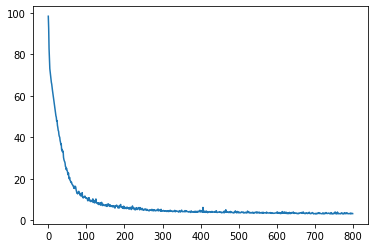

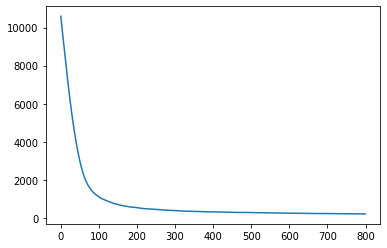

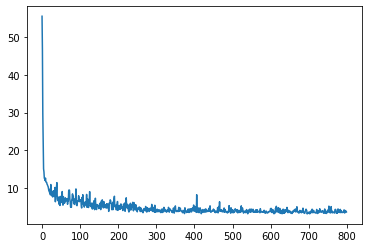

In [133]:
plt.plot(history.history['loss'])
plt.show()
plt.plot(history.history['loss_kl'])
plt.show()
plt.plot(history.history['mse'])
plt.show()

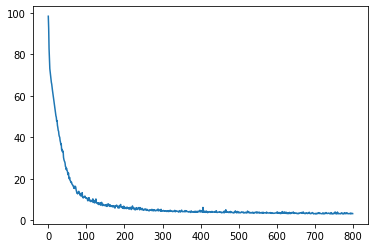

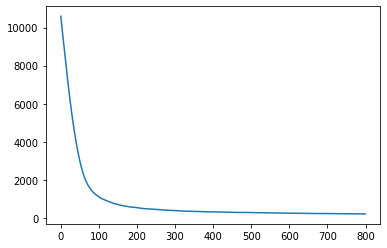

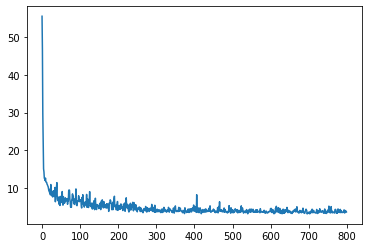

In [134]:
plt.plot(history.history['loss'])
plt.show()
plt.plot(history.history['loss_kl'])
plt.show()
plt.plot(history.history['mse'])
plt.show()
(history)

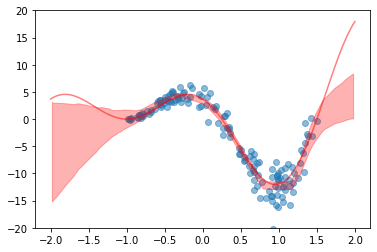

In [140]:
# plot predictions 
plt.scatter(x_train, y_train, alpha=0.5)
xe = np.linspace(-2.0, 2.0, n_val)
ye = func(xe)
plt.plot(xe, ye, c='red', alpha=0.5)

pred_mean = []
for _ in range(100):
    y_pred = model_b(x_val[...,np.newaxis])
    pred_mean.append(y_pred.numpy().squeeze())    
    #pred_std = y_pred.stddev().numpy()
    #pred_std = pred_std.squeeze()
pred_mean = np.stack(pred_mean, axis=0)
pred_min = np.quantile(pred_mean, 0.1, axis=0)
pred_max = np.quantile(pred_mean, 0.9, axis=0)
#plt.scatter(x_val, pred_max, c='red', alpha=0.3)
plt.fill_between(x_val, 
                 pred_min, 
                 pred_max,
                 alpha=0.3, color='red')
plt.ylim(-20, 20)
plt.show()

In [141]:
tmp = np.stack([x_val, pred_min, pred_max], axis=1)
for i in range(tmp.shape[0]):
    print(f'{tmp[i, 0]:.3f} {tmp[i, 1]:.3f} {tmp[i, 2]:.3f}')

-1.983 -15.163 3.148
-1.982 -15.152 3.144
-1.959 -14.800 2.996
-1.923 -14.233 3.021
-1.781 -11.739 2.883
-1.776 -11.673 2.878
-1.708 -10.607 2.765
-1.678 -9.997 2.801
-1.673 -9.912 2.819
-1.664 -9.735 2.857
-1.653 -9.506 2.889
-1.634 -9.135 2.898
-1.616 -8.912 2.857
-1.607 -8.810 2.822
-1.598 -8.707 2.786
-1.596 -8.680 2.779
-1.528 -7.680 2.638
-1.528 -7.674 2.636
-1.527 -7.662 2.632
-1.498 -7.253 2.472
-1.494 -7.209 2.454
-1.465 -6.823 2.432
-1.453 -6.659 2.431
-1.407 -6.043 2.192
-1.407 -6.039 2.190
-1.406 -6.030 2.186
-1.355 -5.161 2.153
-1.331 -4.858 2.211
-1.230 -3.640 1.943
-1.204 -3.305 1.719
-1.167 -2.912 1.652
-1.156 -2.857 1.646
-1.156 -2.856 1.646
-1.152 -2.835 1.647
-1.125 -2.570 1.663
-1.108 -2.397 1.658
-1.083 -2.272 1.682
-1.074 -2.176 1.701
-1.062 -2.010 1.711
-1.047 -1.878 1.745
-1.041 -1.839 1.755
-1.036 -1.814 1.762
-0.974 -1.331 1.715
-0.896 -0.789 1.631
-0.891 -0.772 1.626
-0.887 -0.728 1.617
-0.875 -0.597 1.629
-0.856 -0.434 1.702
-0.829 -0.220 1.786
-0.817 -0.104

In [169]:
tmp = np.stack([x_train, y_train], axis=1)
for i in range(tmp.shape[0]):
    print(f'{tmp[i, 0]:.3f} {tmp[i, 1]:.3f}')

-0.999 -0.122
-0.996 0.012
-0.995 -0.107
-0.993 -0.088
-0.990 0.051
-0.980 0.123
-0.966 -0.323
-0.964 -0.138
-0.963 0.009
-0.959 -0.069
-0.959 -0.013
-0.945 0.178
-0.943 -0.022
-0.939 0.153
-0.938 -0.094
-0.933 0.060
-0.925 0.032
-0.924 -0.020
-0.924 0.168
-0.915 -0.063
-0.910 0.047
-0.906 0.259
-0.896 0.189
-0.894 0.211
-0.887 0.249
-0.884 0.123
-0.884 0.488
-0.882 0.451
-0.877 0.350
-0.875 0.419
-0.874 0.110
-0.870 0.188
-0.860 0.172
-0.859 -0.060
-0.857 -0.001
-0.856 0.107
-0.850 -0.028
-0.848 0.371
-0.846 0.551
-0.843 0.187
-0.843 0.071
-0.841 0.303
-0.837 0.398
-0.831 0.270
-0.830 0.390
-0.827 0.577
-0.823 0.485
-0.818 0.357
-0.812 0.296
-0.795 0.799
-0.786 0.569
-0.780 0.614
-0.778 1.070
-0.766 0.945
-0.751 0.687
-0.746 0.751
-0.743 1.037
-0.739 0.751
-0.736 1.264
-0.736 1.808
-0.725 1.233
-0.713 1.134
-0.712 1.320
-0.705 1.127
-0.700 1.239
-0.695 1.216
-0.694 1.579
-0.685 1.258
-0.683 1.078
-0.680 1.407
-0.680 0.985
-0.679 1.858
-0.674 1.512
-0.670 1.136
-0.667 1.382
-0.660 1.64